<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/08_improving_ocr_with_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Improving OCR with Basic Image Processing

**Reference**

https://github.com/PyImageSearch/imutils

In [ ]:
%%shell

sudo apt install tesseract-ocr
pip install tesseract
pip install pytesseract
pip install Pillow==9.0.0

Just restart the colab environment.

In [1]:
import cv2
import pytesseract
import csv
import numpy as np


from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

%matplotlib inline

In [2]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

Let's download images.

In [ ]:
%%shell

wget https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/images/text-orient-1.png
wget https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/images/text-orient-1.png

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [3]:
def img_display(im_data=None, img_path=None):
    dpi = 80
    if img_path is not None:
      im_data = plt.imread(img_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [4]:
def psm_options(img_path, options=None):
  image = cv2.imread(img_path)

  image_bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # determine the text orientation
  results = pytesseract.image_to_string(image_bgr, config=options)
  return results

In [16]:
def grab_contours(cnts):
  # if the length the contours tuple returned by cv2.findContours
  # is '2' then we are using either OpenCV v2.4, v4-beta, or
  # v4-official
  if len(cnts) == 2:
      cnts = cnts[0]

  # if the length of the contours tuple is '3' then we are using
  # either OpenCV v3, v4-pre, or v4-alpha
  elif len(cnts) == 3:
      cnts = cnts[1]

  # otherwise OpenCV has changed their cv2.findContours return
  # signature yet again and I have no idea WTH is going on
  else:
      raise Exception(("Contours tuple must have length 2 or 3, "
          "otherwise OpenCV changed their cv2.findContours return "
          "signature yet again. Refer to OpenCV's documentation "
          "in that case"))

  # return the actual contours array
  return cnts

##Problem

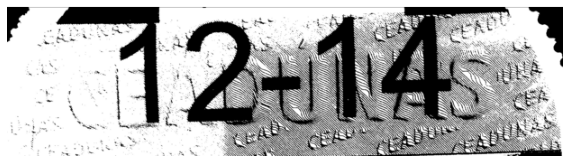

In [ ]:
img_display("aRh8C.png")

In [ ]:
results = psm_options("aRh8C.png")
results

' \n\x0c'

In [ ]:
results = psm_options("aRh8C.png", options="--psm 8")
results

' T2eti@ce\n\x0c'

In [ ]:
results = psm_options("aRh8C.png", options="--psm 7")
results

'\x0c'

Unfortunately, Tesseract, regardless of PSM mode, is utterly failing to OCR this image as is, returning either nothing at all or total gibberish.

Do we mark this image as “impossible to OCR”?

Not so fast — all we need is a bit of image processing.

##Image Processing Pipeline for OCR

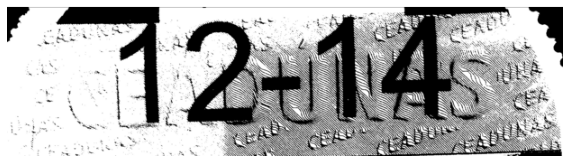

In [6]:
img_display(img_path="aRh8C.png")

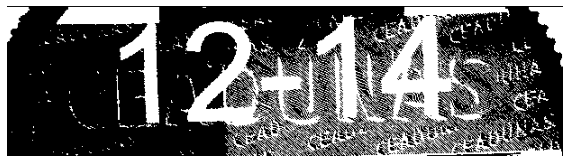

In [12]:
# load the input image and convert it to grayscale
image = cv2.imread("aRh8C.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold the image using Otsu's thresholding method
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
img_display(thresh)

The distance transform starts to reveal the digits themselves, since there is a larger
distance from the foreground pixels to the background. The distance transform has the added
benefit of cleaning up much of the noise in the image’s background.

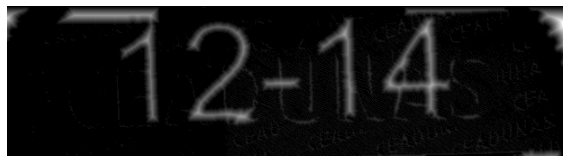

In [13]:
# apply a distance transform
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

# normalize the distance transform
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype("uint8")

img_display(dist)

From there, we apply Otsu’s thresholding method.

Notice that we are not using the inverse binary threshold because we want the text to remain in the foreground (white).

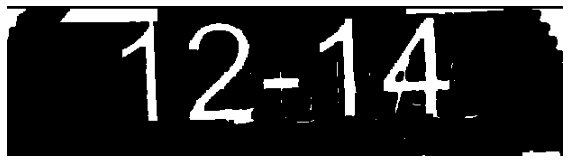

In [14]:
# threshold the distance transform using Otsu's method
dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
img_display(dist)

Let’s continue to clean up our foreground:

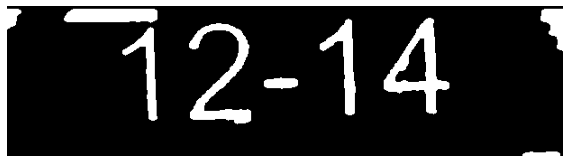

In [17]:
# apply an "opening" morphological operation to disconnect components in the image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel)

img_display(opening)

Applying an opening morphological operation (i.e., dilation followed by erosion) disconnects
connected blobs and removes noise.

Notice that our
opening operation effectively disconnects the “1” character from the blob at the top of the image.

At this point we can extract contours from the image and filter them to reveal only the digits:

In [18]:
# find contours in the opening image
cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)

chars = []
# loop over the contours
for c in cnts:
  # compute the bounding box of the contour
  (x, y, w, h) = cv2.boundingRect(c)
  # check if contour is at least 35px wide and 100px tall
  if w >= 35 and h >= 100:
    chars.append(c)

Extracting contours in a binary image means that we want to find all the isolated foreground
blobs.

After we’ve found all of our contours (cnts) we need to determine which ones to discard and
which to add to our list of characters.

Now that we’ve isolated our character contours, let’s clean up the surrounding area:

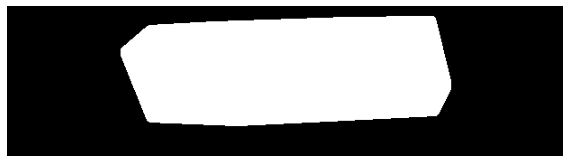

In [19]:
# compute the convex hull of the characters that will enclose all of the digits
chars = np.vstack([chars[i] for i in range(0, len(chars))])
hull = cv2.convexHull(chars)

# allocate memory for the convex hull mask, draw the convex hull on the image, and then enlarge it via a dilation
mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.drawContours(mask, [hull], -1, 255, -1)
# Enlarge (dilate) the mask
mask = cv2.dilate(mask, None, iterations=2)

img_display(mask)

Computing the bitwise AND (between opening and mask), cleans up our
opening image and produces our final image consisting of only the digits and no background noise.

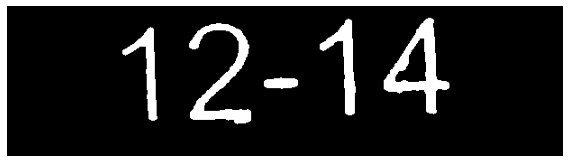

In [20]:
# take the bitwise of the opening image and the mask to reveal *just* the characters in the image
final = cv2.bitwise_and(opening, opening, mask=mask)
img_display(final)

That’s it for our image processing pipeline — we now have a clean image which will play nice with Tesseract. 

Let’s perform OCR and display the results:

In [22]:
# OCR the input image using Tesseract
options="--psm 8 -c tessedit_char_whitelist=0123456789"

text = pytesseract.image_to_string(final, config=options)
print(text)

12-14 -



By using a bit of basic image processing and the OpenCV library, we were able to
clean up our input image and then correctly OCR it using Tesseract, even though Tesseract
was unable to OCR the original input image!